# Comparison

In [1]:
import time
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.font_manager as font_manager
import seaborn as sns
from cycler import cycler

from common import *

%matplotlib inline
import visualization as viz
viz.set_plot_style()

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)

numpy ver.: 1.12.1
pandas ver.: 0.20.1


In [23]:
def comparison_matrix(data):
    models = ['ConvLSTM', 'Historical Average', 'Current Model', 'Google Traffic']
    results = pd.DataFrame(columns = ['Model', 'RMSE (min)', 'MAE (min)', 'MAPE (%)', 'SMAPE (%)'])
    for m in models:
        rmse = np.sqrt(np.mean((data['Ground Truth'] - data[m])**2))
        mae = np.mean(np.abs((data['Ground Truth'] - data[m])))
        mape = np.mean(np.abs((data['Ground Truth'] - data[m])) / data['Ground Truth']) * 100
        smape = np.mean(np.abs((data['Ground Truth'] - data[m])) / (np.abs(data['Ground Truth']) + np.abs(data[m])) / 2) * 100
        results = results.append(pd.DataFrame([[m, rmse, mae, mape, smape]], columns = results.columns), ignore_index = True)
    return results.set_index('Model')

## Load and transform ground truth

In [3]:
data = prep_data('../data/4A_1_201705_201710.csv')
print(len(data))

1213677


Links included in the evaluation, i.e. the first 32 links of 4A in the CCW direction:

In [4]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 32)]
assert len(data['LinkRef'].unique()) == 32
n = len(data)
print(n)

943136


In [5]:
data_train = data[data['DateTime'] < '2017-10-10']
data_test = data[('2017-10-11' <= data['DateTime']) & (data['DateTime'] < '2017-10-14')]

In [6]:
means, scales, low, upr = fit_scale(data_test)

In [7]:
ix, ts, rm_mean, rm_scale, w, k = transform(data_test, means, scales)

In [8]:
ts_true = pd.DataFrame(index = ix, data = ts * rm_scale + rm_mean, columns = k)

In [9]:
ts_convlstm = pd.read_csv('../data/Output-ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison_2.csv', index_col = 0, parse_dates = True)

##  Load comparison data
### Load prepared data for Current Model

In [10]:
ts_cm = pd.read_csv('../data/current_model/data_prepared.csv', index_col = 0, parse_dates = True)

### Load and transform Google Maps Distance Matrix

In [11]:
ts_gmaps = pd.read_csv('../data/google/data_prepared.csv', index_col = 0, parse_dates = True)

### Load and transform Historical Average

In [12]:
ha_means, ha_scales, ha_low, ha_upr = fit_scale(data_train)
ha_ix, _, ha_rm_mean, _, _, _ = transform(data_test, ha_means, ha_scales)
ts_ha = pd.DataFrame(index = ix, data = ha_rm_mean, columns = k)

## Descriptive statistics

Collect statistics into single data frame.

In [20]:
comp = pd.DataFrame(index = ix, data = ts_true.sum(axis = 1) / 60, columns = ['Ground Truth'])
comp['ConvLSTM'] = ts_convlstm.sum(axis = 1) / 60
comp['Historical Average'] = ts_ha.sum(axis = 1) / 60
comp['Current Model'] = ts_cm.sum(axis = 1) / 60
comp['Google Traffic'] = ts_gmaps.sum(axis = 1) / 60
comp['Day'] = comp.index.strftime('%A')
comp_ = comp.between_time('06:00', '22:00')
len(comp_)

195

### Look at a week (06 - 22)

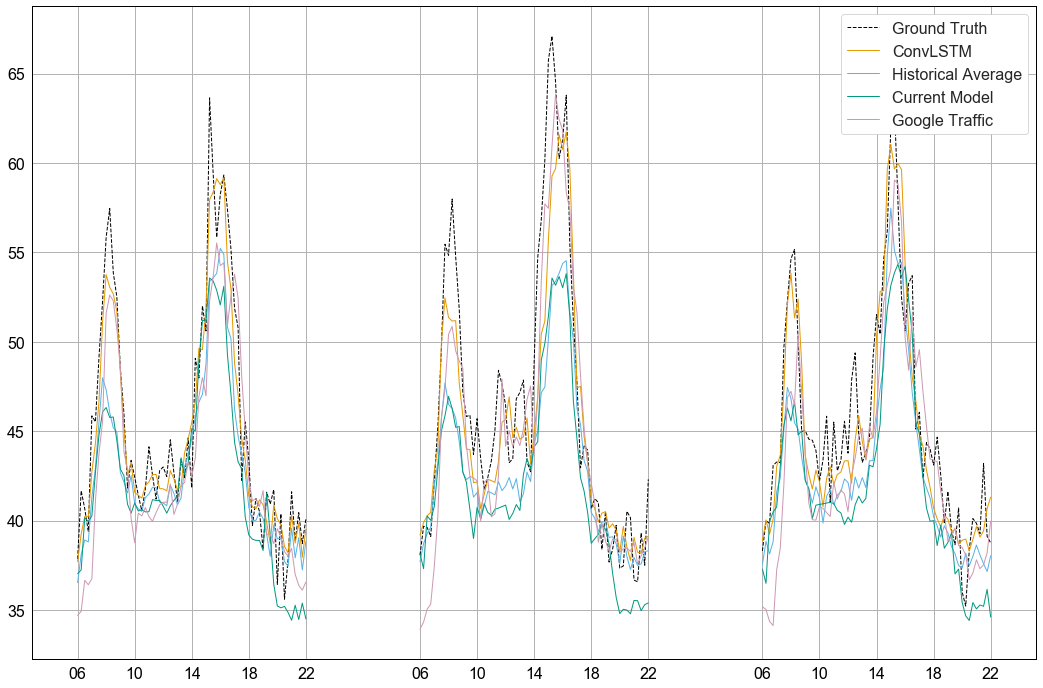

In [21]:
fig, ax = plt.subplots(figsize = (18, 12))
first = True
for key, comp_day in comp_.groupby('Day'):
    a, = plt.plot(comp_day['Ground Truth'], label = 'Ground Truth', color = 'C0', linewidth = 1, linestyle = '--')
    b, = plt.plot(comp_day['ConvLSTM'], label = 'ConvLSTM', color = 'C1', linewidth = 1, linestyle = '-')
    c, = plt.plot(comp_day['Historical Average'], label = 'Historical Average', color = 'C2', linewidth = 1, linestyle = '-')
    d, = plt.plot(comp_day['Current Model'], label = 'Current Model', color = 'C3', linewidth = 1, linestyle = '-')
    e, = plt.plot(comp_day['Google Traffic'], label = 'Google Traffic', color = 'C7', linewidth = 1, linestyle = '-')
    if first:
        ax.legend(handles = [a, b, c, d, e], loc='upper right')
        first = False
        
dt_ix = pd.date_range('2017-10-11 06:00', '2017-10-14', freq = '4H')
ax.set_xticks(dt_ix[dt_ix.indexer_between_time('06:00', '22:00')])
xfmt = md.DateFormatter('%H')
ax.xaxis.set_major_formatter(xfmt)


In [24]:
comparison_matrix(comp_)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,2.657083,1.992956,4.187821,1.062355
Historical Average,4.351046,3.226917,6.508489,1.711483
Current Model,4.917284,3.903671,8.047742,2.134504
Google Traffic,3.667974,2.955556,6.318143,1.637462


### Look at a weekday

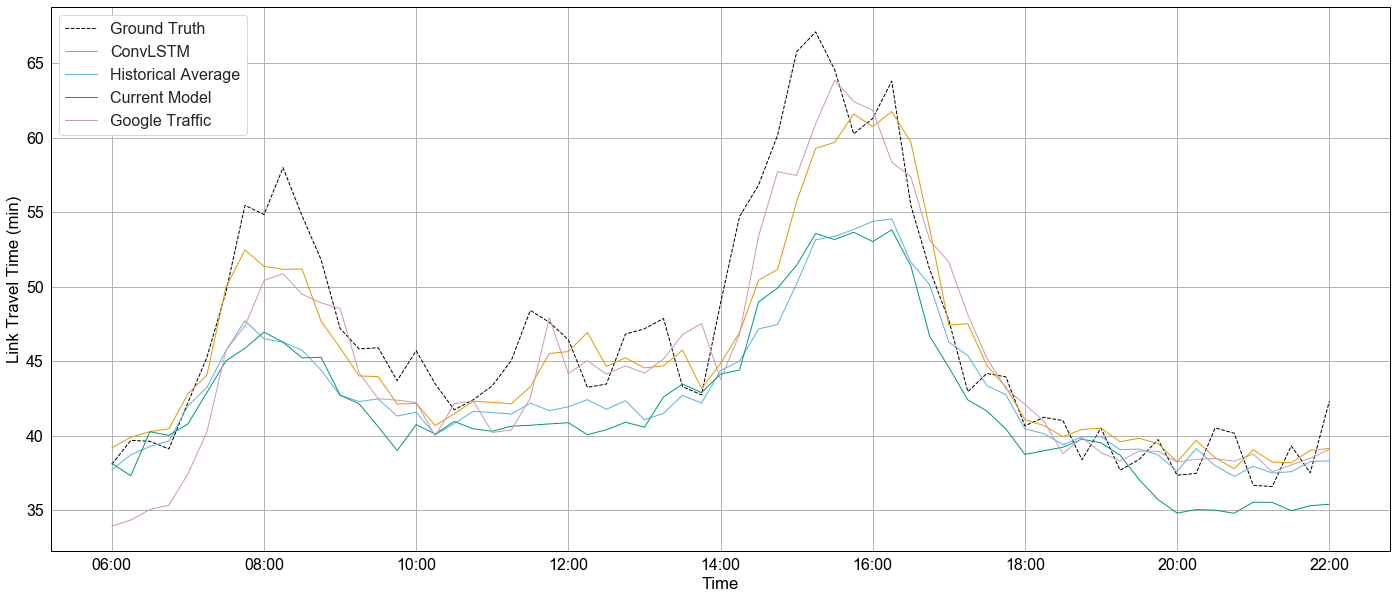

In [25]:
comp_day = comp_[comp_['Day'] == 'Thursday']
fig, ax = plt.subplots(figsize = (24, 10))
a, = plt.plot(comp_day['Ground Truth'], label = 'Ground Truth', color = 'C0', linewidth = 1, linestyle = '--')
b, = plt.plot(comp_day['ConvLSTM'], label = 'ConvLSTM', color = 'C1', linewidth = 1, linestyle = '-')
b, = plt.plot(comp_day['Historical Average'], label = 'Historical Average', color = 'C2', linewidth = 1, linestyle = '-')
c, = plt.plot(comp_day['Current Model'], label = 'Current Model', color = 'C3', linewidth = 1, linestyle = '-')
d, = plt.plot(comp_day['Google Traffic'], label = 'Google Traffic', color = 'C7', linewidth = 1, linestyle = '-')
ax.legend(loc='upper left', )

        
dt_ix = pd.date_range(min(comp_day.index), max(comp_day.index) + pd.to_timedelta('00:15:00'), freq = '2H')
ax.set_xticks(dt_ix[dt_ix.indexer_between_time('06:00', '22:00')])
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel('Time')
ax.set_ylabel('Link Travel Time (min)')

plt.savefig('../paper/plots/comparison_day.pdf', bbox_inches='tight')

In [26]:
comparison_matrix(comp_day)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,3.288721,2.444830,4.937603,1.263882
Historical Average,5.402950,3.894380,7.503325,1.997398
Current Model,5.746930,4.624107,9.228713,2.462309
Google Traffic,3.573152,2.917849,6.124254,1.578922


### Between 14:00 and 18:00

In [27]:
comp_weekdays = comp_[(comp_['Day'] != 'Saturday') & (comp_['Day'] != 'Sunday')].between_time('14:00', '18:00')
comparison_matrix(comp_weekdays)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,3.785718,3.017323,5.609465,1.428019
Historical Average,5.903035,4.649641,8.284098,2.201198
Current Model,6.281810,5.200302,9.369109,2.495019
Google Traffic,4.159223,3.341850,6.208120,1.587893


In [28]:
comp_weekdays = comp_[(comp_['Day'] != 'Saturday') & (comp_['Day'] != 'Sunday')].between_time('07:00', '09:00')
comparison_matrix(comp_weekdays)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,2.641042,2.089638,4.035101,1.032279
Historical Average,6.404508,5.574100,10.618744,2.845877
Current Model,6.693937,5.878947,11.217883,3.014826
Google Traffic,5.252039,4.621399,9.169525,2.434282
